# Simulate acoustic wave propagation of a plane circular piston


The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook showcases the basic functionality to perform acoustic simulations. The simulation consists of plane circular piston in an unbounded water region and a spherical scatterer resembling bone.


## Import the OptimUS library

Load the OptimUS library. Make sure the source code is in the Python path.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

In [3]:
print("OptimUS version:", optimus.__version__)

OptimUS version: 0.0.0


## Specify the physical settings for the simulation

The OptimUS library provides functionality to simulate acoustic wave propagation. For each simulation, one needs to specify the type of source of the acoustic field, the geometry of the scatterer, and the material parameters.

The OptimUS library provides different predefined wave fields, among which is a plane circular piston radiating in 2*pi space. The piston requires the frequency to be specified and, optionally, the source axis, the velocity and its location, which is in this case at [-4, 0, 0].

In [4]:
frequency = 1000
radius = 1
location = [-4, 0, 0]
source = optimus.source.create_piston(frequency, radius=radius, location=location)

Several canonical shapes for scatterers are available in the OptimUS library. Let us use a spherical geometry, by default centered at the origin and unit radius. It is recommended to specify the meshwidth of the triangular surface grid that represents the geometry's surface. A lower value of `h` increases the precision of the algorithm but also the computational costs.

In [5]:
geometry = optimus.geometry.shapes.Sphere(h=0.4)

The exterior medium will be water and the interior medium bone. Default parameters of several materials can be retrieved from OptimUS. Alternatively, the user can create a material with specific values for density and wavespeed.

In [6]:
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. A model with default settings can be used. Alternatively, other boundary integral formulations and preconditioners can be chosen or specified manually.

Each model requires a source and geometry object, as well as the material parameters of the unbounded exterior domain and the bounded interior domain.

In [7]:
model = optimus.model.create_default_model(source, geometry, material_ext, material_int)

After creating the model, it needs to be solved to obtain the surface potentials at the material interface. Depending on the size of the model, this can be computationally expensive. The solution will be stored inside the model object.

In [8]:
model.solve()

## Visualisation of the acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $z=0$.

In [9]:
import bempp.api
import numpy as np
from optimus.source.transducers import transducer_field
from matplotlib import pylab as plt

In [10]:
# Create a visualisation grid
Nx = 100
Ny = 100
xmin, xmax, ymin, ymax = [-3, 3, -3, 3]
zval = 0.0
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    zval*np.ones(plot_grid[0].size)))

# Define the interior and exterior points
x, y = points[:2]
idx_ext = np.sqrt(x**2 + y**2) > 1.0
idx_int = np.logical_not(idx_ext)
points_exterior = points[:, idx_ext]
points_interior = points[:, idx_int]

The incident pressure field is computed at the required locations to calculate the total field

In [11]:
inc_field = transducer_field(source, material_ext, points)
incident_pressure = inc_field.pressure

Calculate the fields from the surface potential with the potential operators.

In [12]:
slp_pot_int = bempp.api.operators.potential.helmholtz.single_layer(
    model.space[0], points_interior, material_int.compute_wavenumber(source.frequency))
slp_pot_ext = bempp.api.operators.potential.helmholtz.single_layer(
    model.space[0], points_exterior, material_ext.compute_wavenumber(source.frequency))
dlp_pot_int = bempp.api.operators.potential.helmholtz.double_layer(
    model.space[0], points_interior, material_int.compute_wavenumber(source.frequency))
dlp_pot_ext = bempp.api.operators.potential.helmholtz.double_layer(
    model.space[0], points_exterior, material_ext.compute_wavenumber(source.frequency))

surfpot_dir_ext, surfpot_neu_ext = model.solution
surfpot_dir_int = surfpot_dir_ext
surfpot_neu_int = (material_int.density / material_ext.density) * surfpot_neu_ext
total_field_int = (slp_pot_int * surfpot_neu_int
                   - dlp_pot_int * surfpot_dir_int).ravel()
total_field_ext = (dlp_pot_ext * surfpot_dir_ext 
                   - slp_pot_ext * surfpot_neu_ext).ravel() + incident_pressure[idx_ext]  

total_field = np.zeros(points.shape[1], dtype='complex128')
total_field[idx_ext] = total_field_ext
total_field[idx_int] = total_field_int

In [ ]:
total_field_plot = np.flipud(total_field.reshape([Nx, Ny]).T)

### Visualisation of real part of total field

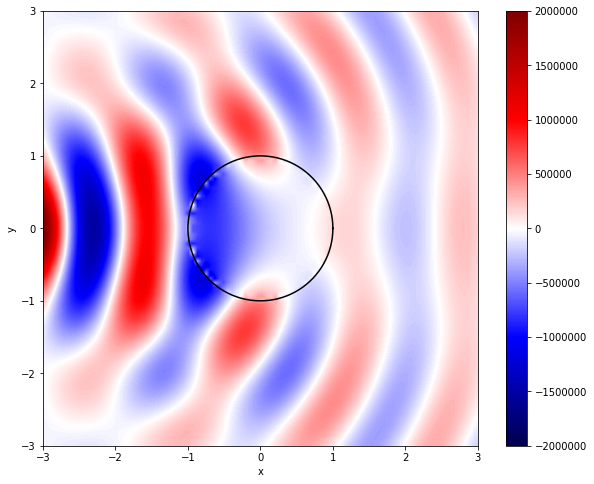

In [13]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.real(total_field_plot), extent=[xmin, xmax, ymin, ymax], clim=[-2e6,2e6], cmap='seismic', interpolation='bilinear')
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

### Visualisation of magnitude of total field

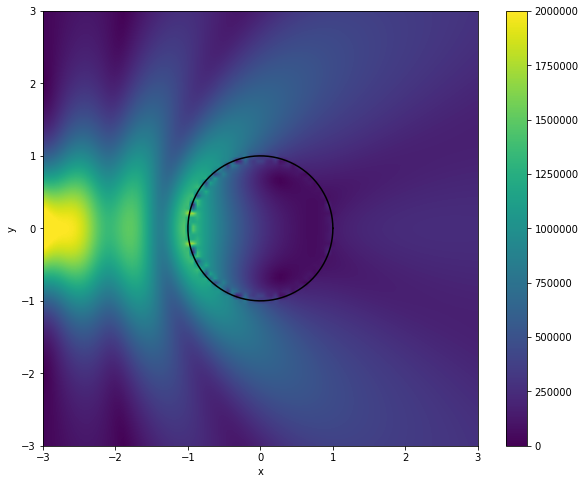

In [14]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.abs(total_field_plot), extent=[xmin, xmax, ymin, ymax], clim=[0,2e6], cmap='viridis', interpolation='bilinear')
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

### Visualisation of magnitude of incident field

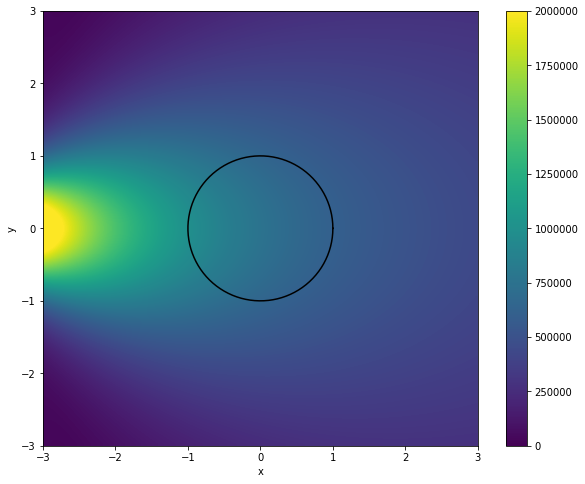

In [15]:
incident_pressure_plot = np.flipud(incident_pressure.reshape([Nx, Ny]).T)
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.abs(incident_pressure_plot), extent=[xmin, xmax, ymin, ymax], clim=[0,2e6], cmap='viridis', interpolation='bilinear')
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()